In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [3]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

from collections import Counter

### specify directory where data is stored

In [4]:
#use this path for personal computer
#diff_exp_data_dir = "/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

#use this path for Gates MRI computer
diff_exp_data_dir = "/Users/RogerVargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

### set parameters for plotting

In [5]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

## *Function* for constructing distribution of edge weights from pooled (significant) logFC changes across datasets

In [6]:
def edge_weight_distribution_from_pooled_logFC(logFC_table_filename):

    # read in CSV file with significant logFC changes for genes between comparison X samples collected from various datasets
    diff_gene_exp_df = pd.read_csv(diff_exp_data_dir + logFC_table_filename).set_index('Unnamed: 0')
    diff_gene_exp_df.rename_axis('gene' , inplace = True)

    # Construct simplified matrix of logFC direction from DataFrame with significant logFC changes across all analyses by converting values:
    # +1 if logFC > 0
    # 0 if logFC = 0
    # -1 if logFC < 0

    # store copy of array from dataframe with sig. logFC values (rows = genes, columns = GSE ID)
    direc_diff_gene_exp_matrix = diff_gene_exp_df.copy().values 

    # replace values in logFC matrix
    direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix > 0.0] = 1
    direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix == 0.0] = 0
    direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix < 0.0] = -1

    # convert to lower memory int8 datatype
    direc_diff_gene_exp_matrix = direc_diff_gene_exp_matrix.astype('int8')

    # compute the dot product between every two pairs of gene vectors (will calculate the edges weights for our network)
    # multiply direction logFC matrix by its transpose to get the dot products between all pairs of rows
    network_edge_weight_matrix = direc_diff_gene_exp_matrix.dot(direc_diff_gene_exp_matrix.T)

    # the row/column annotation (genes) can be copied from the logFC differential gene expression DataFrame
    network_edge_weight_matrix_labels = pd.Series(list(diff_gene_exp_df.index) , index = range(0 , len(diff_gene_exp_df.index)))

    #number of rows / columns
    num_genes = np.shape(network_edge_weight_matrix)[0]

    # retrieve the distribution of the Edge Weights by returning the upper triangular part of the matrix
    edge_weight_array = network_edge_weight_matrix[np.triu_indices(num_genes, k = 0)]
    
    #convert array to a Counter dict to save space (keys: edge weight values, values: count of edge weights in edge weight distribution)
    edge_weight_distr_counter_dict = Counter(list(edge_weight_array))
    
    return edge_weight_distr_counter_dict

    ###########################################################################################
    '''
    # use code below if you only want to return the non-zero edge weights in an array & just calculate
    # the number of zero elements

    # retrieve the distribution of the Edge Weights
    # return the upper triangular part of the matrix with elements in lower part zeroed out
    upper_tri_network_edge_weight_matrix = np.triu(network_edge_weight_matrix, k = 0)

    #Return all non-zero elements in an array
    edge_weight_array = upper_tri_network_edge_weight_matrix[np.nonzero(upper_tri_network_edge_weight_matrix)]

    #get the number of zero elements in the upper triangle of the matrix
    num_elements_lower_triangle = (num_genes*num_genes - num_genes)/2
    num_zero_edge_weigts = np.sum(upper_tri_network_edge_weight_matrix == 0) - num_elements_lower_triangle
    
    return edge_weight_array
    '''
    ###########################################################################################

## *Function* for visualizing distribution of edge weights from pooled (significant) logFC changes across datasets

In [7]:
def plot_distribution_of_edge_weights(ax, edge_weight_distr_counter_dict, plot_title):
    
    #get the keys & values from Counter dict (with Edge Weight distr)
    edge_weight_values = list(edge_weight_distr_counter_dict.keys())
    edge_weight_count = list(edge_weight_distr_counter_dict.values())
    edge_weight_count_norm = np.array(edge_weight_count) / float(np.sum(edge_weight_count)) #normalize counts
    
    ax.bar(edge_weight_values , edge_weight_count_norm, color = 'k' , width = 1.0 , edgecolor='white', linewidth=0.5)
    
    # calculate the proportion of the edges that had weight = 0 (~ sparsity of the edge weight matrix)
    proportion_edge_weight_zero = round(float(edge_weight_distr_counter_dict[0]) / float(np.sum(edge_weight_count)), 4) * 100

    ax.set_title(plot_title, fontsize = 12, color = 'k')
    ax.set_ylabel('Proportion of Edges', fontsize = 12, color = 'k')
    ax.set_xlabel(f'Edge Weights ({proportion_edge_weight_zero}% = 0)' , fontsize = 12, color = 'k')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.set_yscale('log')

    ax.tick_params(labelcolor = 'k')
    ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
    
    for axis in [ax.yaxis]:
        axis.set_major_formatter(FormatStrFormatter('%.5f'))

# ATB v LTBI

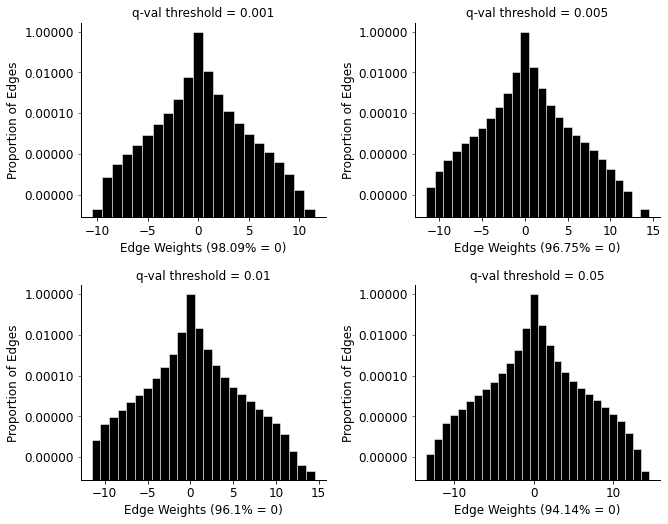

In [8]:
comparison_X = 'ATB_v_LTBI'

fig , axes = plt.subplots(2, 2)

qval_thresh = 0.001
edge_weight_distr_counter_dict = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[0,0], edge_weight_distr_counter_dict, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.005
edge_weight_distr_counter_dict = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[0,1], edge_weight_distr_counter_dict, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.01
edge_weight_distr_counter_dict = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[1,0], edge_weight_distr_counter_dict, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.05
edge_weight_distr_counter_dict = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[1,1], edge_weight_distr_counter_dict, f'q-val threshold = {qval_thresh}')

fig = plt.gcf()
fig.set_size_inches(9.5, 7.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

# ATB v HC

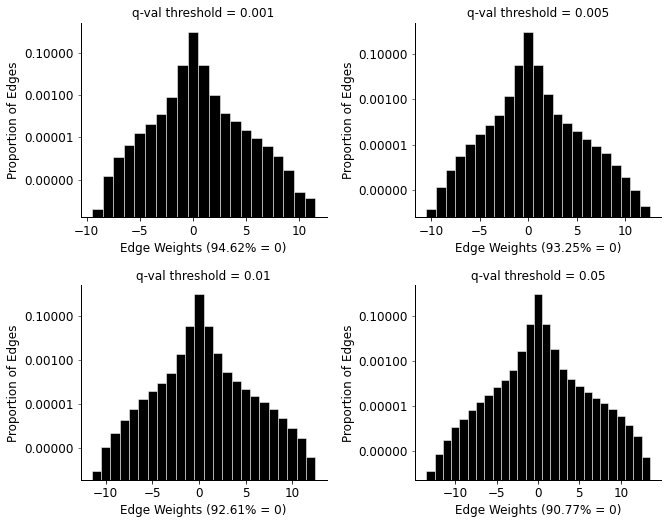

In [9]:
comparison_X = 'ATB_v_HC'

fig , axes = plt.subplots(2, 2)

qval_thresh = 0.001
edge_weight_distr_counter_dict = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[0,0], edge_weight_distr_counter_dict, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.005
edge_weight_distr_counter_dict = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[0,1], edge_weight_distr_counter_dict, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.01
edge_weight_distr_counter_dict = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[1,0], edge_weight_distr_counter_dict, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.05
edge_weight_distr_counter_dict = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[1,1], edge_weight_distr_counter_dict, f'q-val threshold = {qval_thresh}')

fig = plt.gcf()
fig.set_size_inches(9.5, 7.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

# ATB v OD

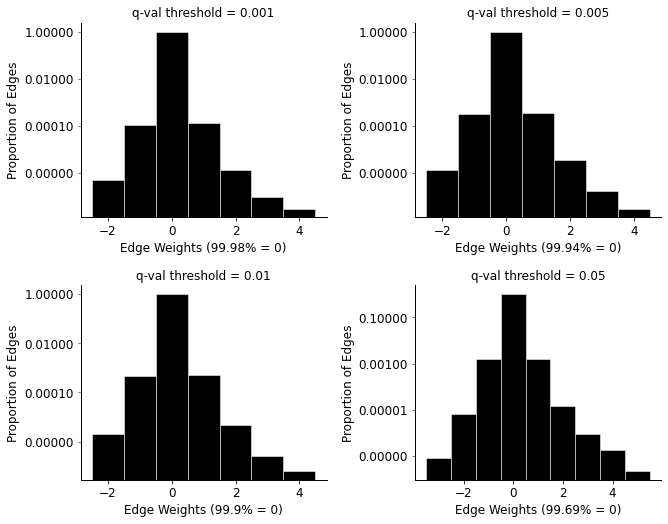

In [10]:
comparison_X = 'ATB_v_OD'

fig , axes = plt.subplots(2, 2)

qval_thresh = 0.001
edge_weight_distr_counter_dict = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[0,0], edge_weight_distr_counter_dict, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.005
edge_weight_distr_counter_dict = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[0,1], edge_weight_distr_counter_dict, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.01
edge_weight_distr_counter_dict = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[1,0], edge_weight_distr_counter_dict, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.05
edge_weight_distr_counter_dict = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[1,1], edge_weight_distr_counter_dict, f'q-val threshold = {qval_thresh}')

fig = plt.gcf()
fig.set_size_inches(9.5, 7.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

# LTBI v HC

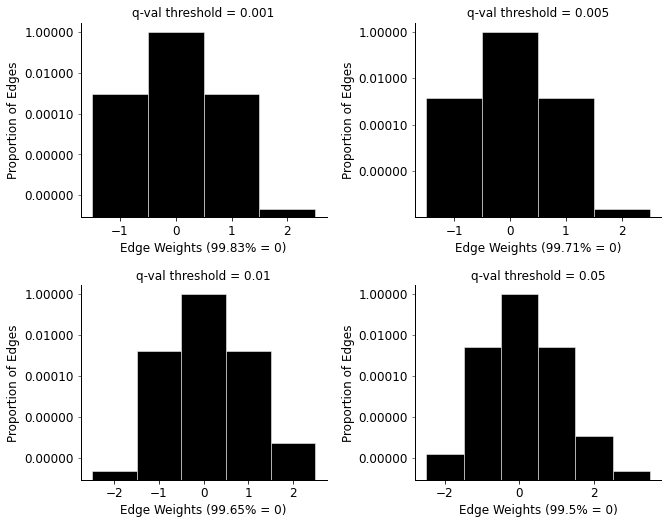

In [11]:
comparison_X = 'LTBI_v_HC'

fig , axes = plt.subplots(2, 2)

qval_thresh = 0.001
edge_weight_distr_counter_dict = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[0,0], edge_weight_distr_counter_dict, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.005
edge_weight_distr_counter_dict = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[0,1], edge_weight_distr_counter_dict, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.01
edge_weight_distr_counter_dict = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[1,0], edge_weight_distr_counter_dict, f'q-val threshold = {qval_thresh}')

qval_thresh = 0.05
edge_weight_distr_counter_dict = edge_weight_distribution_from_pooled_logFC(f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv')
plot_distribution_of_edge_weights(axes[1,1], edge_weight_distr_counter_dict, f'q-val threshold = {qval_thresh}')

fig = plt.gcf()
fig.set_size_inches(9.5, 7.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()